# Figure 6- V2 over time

Want to show the violation rates are stable for V2 animals over long periods of time


In [43]:
import config as c
import utils as u
import behav_viz.ingest as ingest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load


In [ ]:
tdf = ingest.create_trials_df.create_trials_df_from_dj(
    animal_ids=c.V2_ANIMALS,
    date_min=c.DATE_MIN,
    date_max="2025-03-15",
    verbose=True,
)

animal_id R041
dropping 2 sessions of 217 due to <2 trials
Fetched 215 dates from Sessions table from 2024-07-20 to 2025-03-15 for R041

animal_id R043
dropping 0 sessions of 213 due to <2 trials
Fetched 213 dates from Sessions table from 2024-07-20 to 2025-03-15 for R043

animal_id R045
dropping 4 sessions of 207 due to <2 trials
Fetched 203 dates from Sessions table from 2024-07-20 to 2025-03-15 for R045

animal_id R047
dropping 6 sessions of 212 due to <2 trials
Fetched 206 dates from Sessions table from 2024-07-20 to 2025-03-15 for R047

animal_id R049
dropping 1 sessions of 200 due to <2 trials
Fetched 199 dates from Sessions table from 2024-07-29 to 2025-03-15 for R049

animal_id R051
dropping 4 sessions of 210 due to <2 trials
Fetched 206 dates from Sessions table from 2024-07-27 to 2025-03-15 for R051

animal_id R053
dropping 2 sessions of 52 due to <2 trials
Fetched 50 dates from Sessions table from 2024-07-27 to 2024-09-21 for R053

animal_id R055
dropping 9 sessions of 200 d

In [12]:
tdf = tdf.query("stage == 11 and animal_id != 'R053'") # R053 did not continue training
tdf = u.compute_days_relative_to_stage(tdf, stage=11)

In [16]:
tdf.to_pickle("V2_tdf_stage_11.pkl") # TODO move this to the fetch_data notebook

In [14]:
tdf.groupby("animal_id").days_relative_to_stage_11.max()

animal_id
R041    179
R043    183
R045    171
R047    160
R049    164
R051    178
R055    161
R057    177
Name: days_relative_to_stage_11, dtype: int64

In [23]:
stage11_summary_df = tdf.groupby(["animal_id", "days_relative_to_stage_11"]).agg(
    violation_rate=("violation_rate", "mean"),
    n_trials=("trial", "count"),
    fixation_duration=("fixation_dur", "max"),
).reset_index()

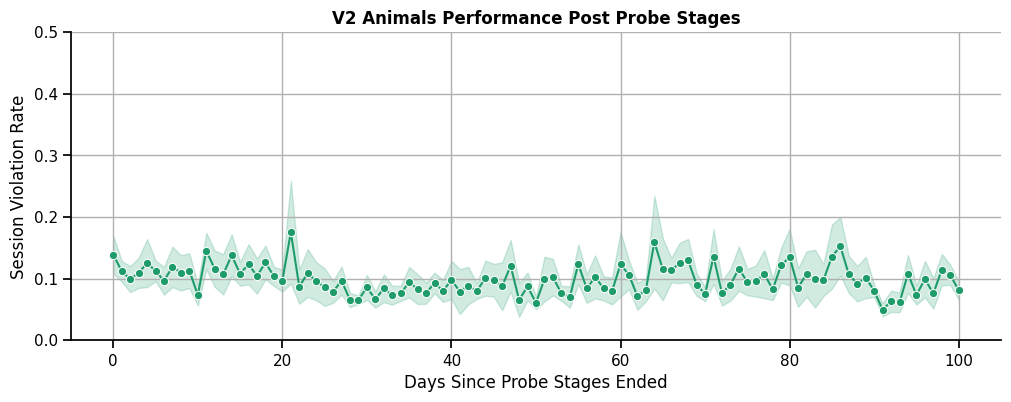

In [48]:
COMMON_CUT_OFF = 100
plot_df = stage11_summary_df.query("days_relative_to_stage_11 <= @COMMON_CUT_OFF")

fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=plot_df, x="days_relative_to_stage_11", y="violation_rate", ax=ax, errorbar="se", marker="o", color=c.EXP_PALETTE[1])

ax.grid(True)

ax.set(
    xlabel="Days Since Probe Stages Ended",
    ylabel="Session Violation Rate",
    ylim=(0, 0.5)
)

ax.set_title("V2 Animals Performance Post Probe Stages", fontweight="bold")

sns.despine()




In [51]:
stats = plot_df['violation_rate'].agg(['median', 'mean', 'std', 'size']).reset_index()
stats

,index,violation_rate
0,median,0.072692
1,mean,0.098788
2,std,0.082297
3,size,808.000000


/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_78270/777281119.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = stats.iloc[1][1]
/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_78270/777281119.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = stats.iloc[2][1]


Text(0.5, 1.0, 'Summary Performance Post Probe Stages\n (N=8, 100 days post-probe, Mean = 0.10, Std = 0.08)')

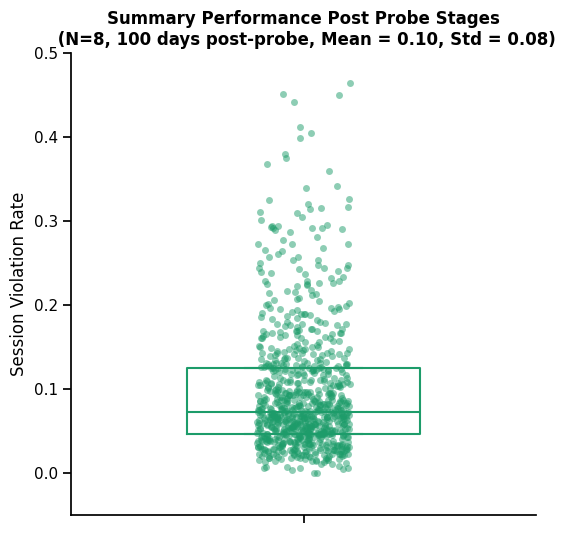

In [68]:
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()

sns.boxplot(
    y="violation_rate",
    data=plot_df,
    ax=ax,
    color=c.EXP_PALETTE[1],
    fill=False,
    showfliers=False,
    whis=0,
    width=0.5,
)


sns.stripplot(
    y="violation_rate",
    data=plot_df,
    ax=ax,
    color=c.EXP_PALETTE[1],
    legend=False,
    alpha=0.5,
)

ax.set(
    ylabel="Session Violation Rate",
    ylim=(-0.05, 0.5)
)

mean = stats.iloc[1][1]
std = stats.iloc[2][1]
ax.set_title(f"Summary Performance Post Probe Stages\n (N=8, 100 days post-probe, Mean = {mean:.2f}, Std = {std:.2f})", fontweight="bold")